# Data Science 1 Final Assignment

In [374]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [375]:
np.random.seed(20240313)

# 1

## A.: How does the regularized estimator (predictor) βˆridge 0 compare with the OLS estimator?

The difference between the OLS estimator and the regularized estimator β^ridge0, is that the latter one introduces a positive constant penalty term parameter, which penalizes large regression coefficients and gives larger penalty for a larger parameter.

The β^ridge estimator is a biased version of β and has a lower variance than the OLS.

## B.: Beta ridge

In [376]:
# Simplest possible predictive model

# Suppose that β0 = 1 and ϵ ∼ N(0, σ) with σ2 = 4. Sample size of 20

# Define the "function"
Beta0 = 1

# Sample size
n = 20

# Epsilon aka noise
epsilon = np.random.normal(0, 2, n)


Y = Beta0 + epsilon

# collect results into a DataFrame
result_columns = ["Lambda", "Ridge"]
df = pd.DataFrame(columns=result_columns)

#Init
lambresults = []

#Ridge solution
for lamb in range(20):

    loop = []
    for i in range(n):
        loop.append(Y[i]/(n+lamb+1))

    lambresults.append(sum(loop))


# Organize
df = pd.DataFrame({
    'Lambda': np.arange(1,21,1),
    'Results': lambresults
})

df

,Lambda,Results
0,1,1.478119
1,2,1.410932
2,3,1.349587
3,4,1.293354
4,5,1.241620
5,6,1.193865
6,7,1.149648
7,8,1.108589
8,9,1.070362
9,10,1.034683


## C.: Repeat 1000 times

In [377]:
results = []
#Repeat part b), say, 1000 times
R = 1000

Beta0 = 1
n = 20
for _ in range(R):
    epsilon = np.random.normal(0, 2, n)
    Y = Beta0 + epsilon

    lambresults = []
    for lamb in range(20):

        loop = []
        for i in range(n):
            loop.append(Y[i]/(n+lamb+1))

        lambresults.append(sum(loop))
    
    results.append(lambresults)




# Compute bias2, variance and MSE
results = np.array(results)
bias2 = (np.mean(results, axis=0) - Beta0)**2
variance = np.var(results, axis=0)
mse = np.mean((results - Beta0) ** 2, axis=0)

# Organize results into a table
df = pd.DataFrame({
    'Lambda': np.arange(1,21,1),
    'bias2': bias2.flatten(),
    'variance': variance.flatten(),
    'MSE': mse.flatten()
})
df

,Lambda,bias2,variance,MSE
0,1,0.001220,0.195329,0.196549
1,2,0.006209,0.177975,0.184185
2,3,0.014126,0.162835,0.176961
3,4,0.024201,0.149549,0.173749
4,5,0.035851,0.137824,0.173675
5,6,0.048630,0.127426,0.176056
6,7,0.062197,0.118162,0.180358
7,8,0.076286,0.109872,0.186159
8,9,0.090696,0.102426,0.193122
9,10,0.105270,0.095711,0.200981


## D.: Plot

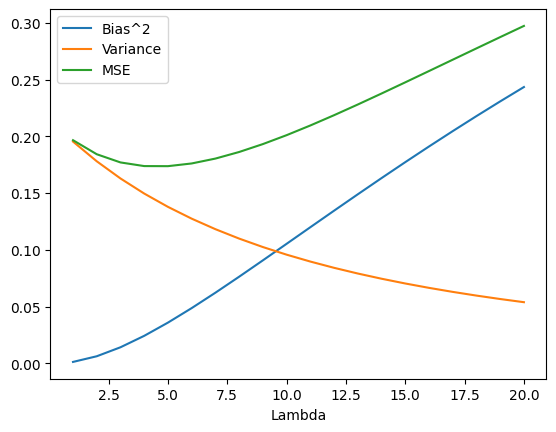

In [378]:
plt.plot(np.arange(1,21,1), bias2, label='Bias^2')
plt.plot(np.arange(1,21,1), variance, label='Variance')
plt.plot(np.arange(1,21,1), mse, label='MSE')
plt.xlabel('Lambda')
plt.legend()
plt.show()

# 2

## A.: As we increase s from 0, the training RSS will:

IV. Steadily decrease

The minimization is like the selection of the parameters in the LASSO model. RSS equeals to the minimization and increasing the value of s, will ultimately leads to a decrease of it for the training, as sum|βj | ≤ s, and from the minimization, we subtract sum|βj |, leading a decreasing value.

## B.: Repeat (a) for test RSS

II. Decrease initially, and then eventually start increasing in a U shape.

An increase of s leads to an increased flexibility for the model, where the RSS for the test will decrease, until it reaches the point, where it starts to overfit. From this point, the RSS will start to increase, creating an U shape.

## C.: Repeat (a) for variance

III. Steadily Increase

As s increasing, the flexibility of the model increases as well, thus the variance will also increase at the end.

## D.: Repeat (a) for (squared) bias.

IV. Steadily decrease

The increase of the model's flexibility leads to a decrease on the squared bias.

## E.: Repeat (a) for the irreducible error.

V. Remain constant

The irreducible error is the variance of the noise ϵ. Because ϵ is independent from X and Y, increasing the value of s, won't change ϵ.

# 3

## Preperation

In [379]:
# Generate correlated features
def generateRandomCovarianceVarianceMatrix(n_features):
    random_matrix = np.random.rand(n_features, n_features)

    # Create a symmetric matrix by taking the average of the matrix and its transpose
    var_cov_matrix = (random_matrix + random_matrix.T) / 2
    
    # Ensure the diagonal elements represent variances (non-negative values)
    var_cov_matrix[np.diag_indices(n_features)] = np.abs(var_cov_matrix[np.diag_indices(n_features)])

    # Ensure positive semidefiniteness
    eigenvalues, eigenvectors = np.linalg.eigh(var_cov_matrix)
    eigenvalues[eigenvalues < 0] = 0  # Replace negative eigenvalues with 0
    var_cov_matrix = np.dot(eigenvectors, np.dot(np.diag(eigenvalues), eigenvectors.T))

    return var_cov_matrix

def generateCorrelatedFeatures(n_features, n_samples, vc_matrix=None):
    if vc_matrix is None:
        vc_matrix = generateRandomCovarianceVarianceMatrix(n_features)
        
    return np.random.multivariate_normal(np.repeat(0, n_features), vc_matrix, size=n_samples)
    

In [380]:
# dense beta
Beta0 = 1

Betas = np.random.uniform(0,1,50)

## A.: Load data, declare train and test set

In [381]:
# Read CSV
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/Data_Science_1_Final_Assignment/main/PCA_data.csv")

In [382]:
# train and test data
data_train = data[:500]
data_test = data[500:]

#(X1 - X50)
variables = data.iloc[:, 1:51]
print('Dimensions of variables dataframe:', variables.shape)

Dimensions of variables dataframe: (1000, 50)


## B.: Compute the first 10 principal components

In [383]:
# Declare PCA
pca = PCA(n_components=10)

# Fit the PCA model to the data
principal_components = pca.fit_transform(variables)

In [384]:
# First 10 principal component for every feature
principal_components[:,0:10]

array([[ 1.55100242, -2.97019884,  0.26666944, ..., -1.88455425,
         1.26002687, -1.04154732],
       [ 2.7965543 , -2.47836826, -0.53786032, ..., -2.157129  ,
        -0.3719966 , -0.73044631],
       [-4.25873172, -2.64691161,  0.10108602, ...,  1.01504052,
         0.33772198,  0.22666609],
       ...,
       [-0.83807422,  4.70691391,  1.03658506, ..., -0.96908548,
        -2.11933201, -0.7523845 ],
       [ 0.8590044 , -0.01541239,  0.88191941, ..., -3.6143217 ,
         2.57594036,  1.0558713 ],
       [-0.47049128, -2.16708362,  1.51996462, ..., -0.36600118,
        -0.06790252,  1.36274528]])

## C-D.: estimate OLS/PCA over train data and predict test data

In [385]:
#Create X with noise and Y from train data
X_train = np.array(data_train.iloc[:,1:51]) 
Y_train = np.array(data_train.iloc[:,0])

#Create X and Y from test data
X_test = np.array(data_test.iloc[:,1:51])
Y_test = np.array(data_test.iloc[:,0])

mse_results = []

In [386]:
# OLS
linreg_all_features = LinearRegression().fit(X_train, Y_train)
prediction = linreg_all_features.predict(X_test)
mse_all = np.mean((prediction - Y_test)**2)
mse_results.append(mse_all)

In [387]:
# get the training part of the principal components
principal_components = principal_components[:500]

# TODO: Calculate MSE of OLS models by changing how many principal components is used
for i in [1,5,10]:
    n_pc = i
    linreg_pca = LinearRegression().fit(principal_components[:,:n_pc], Y_train)
    prediction = linreg_pca.predict(pca.transform(X_test)[:,:n_pc])
    mse_pca = np.mean((prediction - Y_test)**2)
    mse_results.append(mse_pca)

C:\Users\Szabados\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\Szabados\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\Szabados\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [388]:
df = pd.DataFrame({
    'Model': ["OLS","PCA = 1","PCA = 5","PCA = 10"],
    'Results N = 500': mse_results
})

df

,Model,Results N = 500
0,OLS,4.334077
1,PCA = 1,15.006067
2,PCA = 5,12.924215
3,PCA = 10,8.459278


## E.: Explaining the Slide

- N = 75:
    - In a sample size of 75, the best predictor is the PCA with 10 features, while those PCA where only 5 and 1 features have been used, did worse. OLS was the second best in this sample size.

- N = 500:
    - In a sample size of 500, the best predictor is the OLS, by a mile, while for the PCAs, their own rankings between themselves stayed the same, where using more features is better.

Overally, we can see a trend, where if we increase the sample size, the OLS as a predictor model get's better and better. This is also true for the three PCA model, but they does not get better as much, as the OLS.

My opinion is about this slide, that if our sample size is low, the PCA model with more features predicts better, than the OLS, but if our sample is big enough or we can increase it, then the OLS will have a better result over the PCA models.